In [9]:
import pandas as pd
import sys
sys.path.append('C:\\Users\\david\\Desktop\\David\\FIB\\ReduMetrics\\src\\metrics')

from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import time

from cdc import centroid_distance_correlation
from k_ncp import k_nearest_class_preservation
from spearman import spearman_correlation
from rta import rta_score
from ulse import ulse_score_sklearn
from ulse import ulse_score


In [10]:
original = pd.read_csv('fashion_mnist_flattened.csv', header=None)
pca = pd.read_csv('fashion_mnist_pca.csv')
tsne = pd.read_csv('fashion_mnist_tsne.csv')
umap = pd.read_csv('fashion_mnist_umap.csv')

labels = original[original.columns[-1]]
features = original.iloc[:, :-1]

In [11]:
df = pd.concat([features, labels.rename('label')], axis=1).reset_index(drop=True)
df_sub = df.groupby('label').sample(n=1000, random_state=0).reset_index(drop=True)

indexes = df_sub.index
X_orig = df_sub.drop(columns='label').to_numpy()
y = df_sub['label'].to_numpy()

X_pca = pca.loc[indexes].to_numpy()
X_tsne = tsne.loc[indexes].to_numpy()
X_umap = umap.loc[indexes].to_numpy()

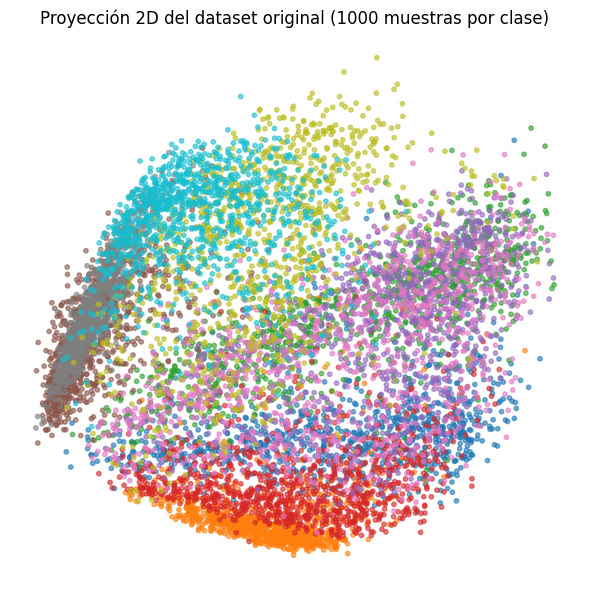

In [12]:
X_vis = PCA(n_components=2, random_state=0).fit_transform(X_orig)
colors = plt.cm.tab10(y.astype(int) % 10)

plt.figure(figsize=(6, 6))
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=colors, s=10, alpha=0.6)
plt.title("Proyección 2D del dataset original (1000 muestras por clase)")
plt.axis('off')
plt.tight_layout()
plt.show()
plt.show()

In [13]:
k_values = [5, 10, 20]
T_values = [5000, 10000]
P_values = [100, 500]

In [14]:
print("=== ULSE (KNN sklearn vs custom) ===")
for k in k_values:
    t0 = %timeit -o -q ulse_score(X_orig, X_pca, k)
    t1 = %timeit -o -q ulse_score_sklearn(X_orig, X_pca, k)
    print(f"k={k}: custom={t0.best:.4f}s, sklearn={t1.best:.4f}s")
print("\n=== RTA ===")
for T in T_values:
    t = %timeit -o -q rta_score(X_orig, X_pca, T, random_state=0)
    val = rta_score(X_orig, X_pca, T, random_state=0)
    print(f"T={T}: val={val:.4f}, time={t.best:.4f}s")
    print("\n=== Spearman ===")
for P in P_values:
    t = %timeit -o -q spearman_correlation(X_orig, X_pca, P, random_state=0)
    val = spearman_correlation(X_orig, X_pca, P, random_state=0)
    print(f"P={P}: val={val:.4f}, time={t.best:.4f}s")
    print("\n=== k-NCP y CDC ===")
import time
start = time.perf_counter(); kncp = k_nearest_class_preservation(X_orig, X_pca, y); dt = time.perf_counter()-start
print(f"k-NCP: {kncp:.4f}, time={dt:.4f}s")
start = time.perf_counter(); cdc = centroid_distance_correlation(X_orig, X_pca, y); dt = time.perf_counter()-start
print(f"CDC:  {cdc:.4f}, time={dt:.4f}s")

=== ULSE (KNN sklearn vs custom) ===
k=5: custom=74.4114s, sklearn=1.9534s
k=10: custom=84.4789s, sklearn=2.0461s
k=20: custom=82.1463s, sklearn=2.1120s

=== RTA ===
T=5000: val=0.4824, time=0.1462s

=== Spearman ===
T=10000: val=0.4853, time=0.2878s

=== Spearman ===
P=100: val=-0.0278, time=0.0009s

=== k-NCP y CDC ===
P=500: val=0.0004, time=0.0090s

=== k-NCP y CDC ===
k-NCP: 0.2333, time=0.0251s
CDC:  -0.1756, time=0.0264s


In [15]:
for name, func in [
    ("ULSE", lambda: ulse_score(X_orig, X_pca, k)),
    ("RTA", lambda: rta_score(X_orig, X_pca, T, 0)),
    ("Spearman", lambda: spearman_correlation(X_orig, X_pca, P, 0)),
    ("k‑NCP", lambda: k_nearest_class_preservation(X_orig, X_pca, y)),
    ("CDC", lambda: centroid_distance_correlation(X_orig, X_pca, y)),
]:
    start = time.perf_counter()
    val = func()
    elapsed = time.perf_counter() - start
    print(f"{name}: {val:.4f} (tiempo: {elapsed:.2f} s)")


ULSE: 0.0519 (tiempo: 87.41 s)
RTA: 0.4853 (tiempo: 0.30 s)
Spearman: 0.0004 (tiempo: 0.01 s)
k‑NCP: 0.2333 (tiempo: 0.03 s)
CDC: -0.1756 (tiempo: 0.03 s)
